In [1]:
import sys
sys.path.append("/home/jaxmao/JaxMao")
sys.path

['/home/jaxmao/JaxMao/Example',
 '/home/jaxmao/miniconda3/envs/jaxlab/lib/python311.zip',
 '/home/jaxmao/miniconda3/envs/jaxlab/lib/python3.11',
 '/home/jaxmao/miniconda3/envs/jaxlab/lib/python3.11/lib-dynload',
 '',
 '/home/jaxmao/miniconda3/envs/jaxlab/lib/python3.11/site-packages',
 '/home/jaxmao/JaxMao']

In [4]:
import jax.numpy as jnp
from jax import jit, value_and_grad
from jax import random

import pandas as pd
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

seed = 42
key = random.PRNGKey(seed)

In [5]:
df = pd.read_csv('datasets/AirPassengers.csv', usecols=[1])
df.head()

,#Passengers
0,112
1,118
2,132
3,129
4,121


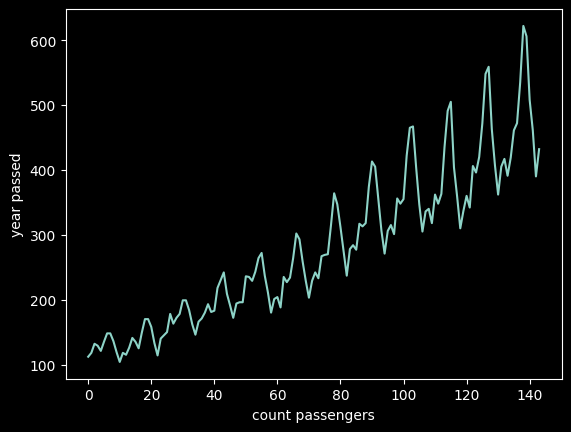

In [6]:
dataset = (df.values).astype('float32')

plt.plot(dataset)
plt.xlabel('count passengers')
plt.ylabel('year passed')
plt.show()

In [7]:
train_size = int(len(dataset)*0.7)
test_size = len(dataset) - train_size
train_unscaled, test_unscaled = dataset[:train_size], dataset[train_size:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_unscaled)
test = scaler.transform(test_unscaled)

In [8]:
def to_sequence(dataset, sequence_length):
    x = []
    y = []
    
    output_sample = len(dataset)- sequence_length - 1
    for i in range(output_sample):
        window = dataset[i:(i+sequence_length), 0]
        x.append(window)
        y.append(dataset[(i+sequence_length), 0])
    return jnp.array(x).reshape(output_sample, sequence_length, 1), jnp.array(y)

sequence_length = 5
trainX, trainY = to_sequence(train, sequence_length)
testX, testY = to_sequence(test, sequence_length)

In [9]:
# Model
from jaxmao.Modules import Module
from jaxmao.Layers import SimpleRNN, FC
from jaxmao.Activations import ReLU

# Training
from jaxmao.Optimizers import GradientDescent
from jaxmao.Losses import MeanSquaredError
        
class SimpleRNN_PredictNumberOfAirPassenger(Module):
    def __init__(self, 
                 num_features=1
        ):
        self.rnn1 = SimpleRNN(num_features, 64)
        self.fc1 = FC(64, 32)
        self.fc2 = FC(32, 1)
        self.relu = ReLU()

    def __call__(self, x):
        x = self.relu(self.rnn1(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

RNNmodel = SimpleRNN_PredictNumberOfAirPassenger()
RNNmodel.init_params(key)

In [11]:
loss_mse = MeanSquaredError()

def loss_params(params, x, y):
    pred = RNNmodel.forward(params, x)
    return loss_mse(pred, y)

grad_loss = jit(value_and_grad(loss_params))

In [12]:
optimizer = GradientDescent()

def training_loop(x, y, epochs=20, lr=0.01, batch_size=32):
    num_batches = len(x) // batch_size

    for epoch in range(epochs):
        x, y = shuffle(x, y)
        for batch_idx in range(num_batches):
            starting_idx = batch_idx * batch_size
            ending_idx = (batch_idx + 1) * batch_size
            batch_x = x[starting_idx:ending_idx]
            batch_y = y[starting_idx:ending_idx]

            losses, gradients = grad_loss(RNNmodel.params, batch_x, batch_y)
            RNNmodel.params = optimizer(RNNmodel.params, gradients, lr=lr)
        if (epoch+1) % 1 == 0:
            print("Epoch: {}\tbatch loss: {}".format(epoch+1, losses/batch_size))
    
    return RNNmodel.params

params = training_loop(
        trainX, trainY, 
        epochs=15, lr=0.0001, batch_size=8
    )

Epoch: 1	batch loss: 0.7490125894546509
Epoch: 2	batch loss: 0.1602976769208908
Epoch: 3	batch loss: 0.04894692450761795
Epoch: 4	batch loss: 0.01574067398905754
Epoch: 5	batch loss: 0.03829806298017502
Epoch: 6	batch loss: 0.06693628430366516
Epoch: 7	batch loss: 0.03637571632862091
Epoch: 8	batch loss: 0.022711198776960373
Epoch: 9	batch loss: 0.08227095752954483
Epoch: 10	batch loss: 0.06823365390300751
Epoch: 11	batch loss: 0.07596127688884735
Epoch: 12	batch loss: 0.044260174036026
Epoch: 13	batch loss: 0.11899374425411224
Epoch: 14	batch loss: 0.04411450773477554
Epoch: 15	batch loss: 0.04547502100467682


In [13]:
trainPredict = RNNmodel.forward(RNNmodel.params, trainX)
testPredict = RNNmodel.forward(RNNmodel.params, testX)

from sklearn.neighbors import KNeighborsRegressor
kNN_reg = KNeighborsRegressor()
kNN_reg.fit(trainX.reshape(-1,5), trainY)
trainPredict_kNN = kNN_reg.predict(trainX.reshape(-1,5))
testPredict_kNN  = kNN_reg.predict(testX.reshape(-1,5))

r2_score of RNN:  0.6502680627509487
r2_score of KNeighbors :  0.8934821450831161


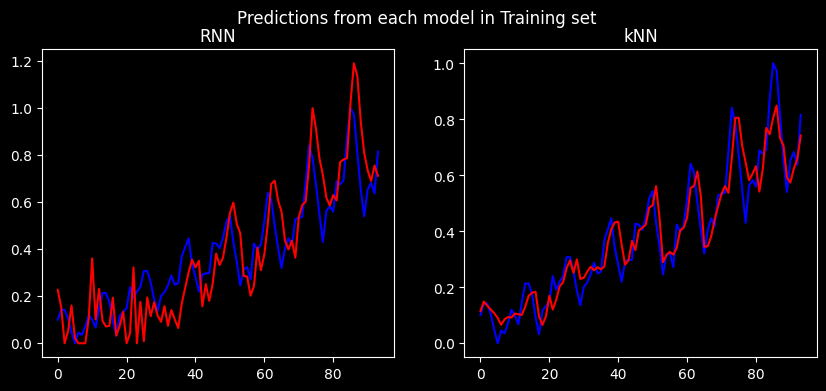

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

print("r2_score of RNN: ", r2_score(trainY, trainPredict))
print("r2_score of KNeighbors : ", r2_score(trainY, trainPredict_kNN))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Predictions from each model in Training set')
predictions = [trainPredict, trainPredict_kNN]
titles = ['RNN', 'kNN']
for ax, prediction, title in zip(axs.ravel(), predictions, titles):
    ax.plot(trainY, c='b')
    ax.plot(prediction, c='r')
    ax.set_title(title)

r2_score of RNN:  0.2638265363509854
r2_score of KNeighbors :  -1.004033397540284


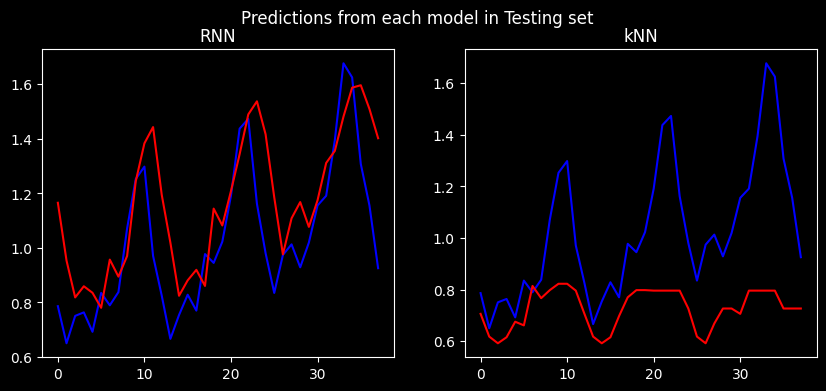

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

print("r2_score of RNN: ", r2_score(testY, testPredict))
print("r2_score of KNeighbors : ", r2_score(testY, testPredict_kNN))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Predictions from each model in Testing set')
predictions = [testPredict, testPredict_kNN]
titles = ['RNN', 'kNN']
for ax, prediction, title in zip(axs.ravel(), predictions, titles):
    ax.plot(testY, c='b')
    ax.plot(prediction, c='r')
    ax.set_title(title)